In [ ]:
!pip install nltk

# Import required libraries


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from string import punctuation 
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
import nltk 


In [102]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
nltk.download('punkt_tab')

In [103]:
train_data = pd.read_csv('train.csv', encoding='unicode_escape')
test_data = pd.read_csv('test.csv', encoding='unicode_escape')
train_data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [104]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data preprocessing steps.


In [105]:
df = pd.concat([train_data,test_data])

In [106]:
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text
df['clean_text'] = df['text'].apply(remove_unnecessary_characters)

In [107]:
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []
df['tokens'] = df['text'].apply(tokenize_text)

In [108]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),clean_text,tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,Id have responded if I were going,"[I, `, d, have, responded, ,, if, I, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0,Sooo SAD I will miss you here in San Diego,"[Sooo, SAD, I, will, miss, you, here, in, San,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,my boss is bullying me,"[my, boss, is, bullying, me, ...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0,what interview leave me alone,"[what, interview, !, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0,Sons of why couldnt they put them on the relea...,"[Sons, of, *, *, *, *, ,, why, couldn, `, t, t..."


In [109]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['normalized_text'] = df['text'].apply(normalize_text)

In [111]:
df.dropna(inplace=True)


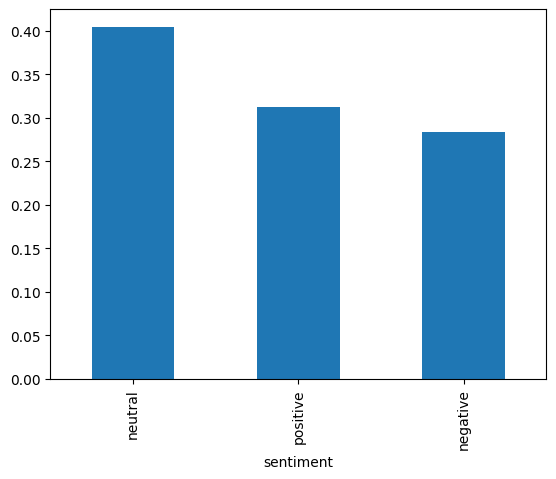

In [112]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');


In [113]:
df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

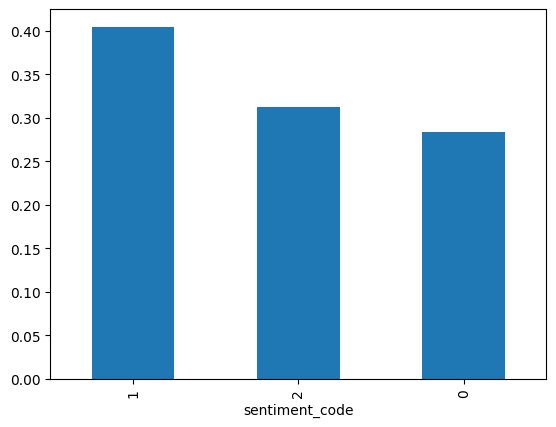

In [114]:
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes
sentiment_distribution = df['sentiment_code'].value_counts(normalize=True)
sentiment_distribution.plot(kind='bar')
plt.show()

# Feature extraction processes

In [115]:
final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [116]:
df=df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [117]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

### Load pre-processed data (df with 'selected_text' and 'sentiment')


In [118]:
X=df['selected_text']
y= df['sentiment']

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### TF-IDF Vectorization

In [120]:
vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(X)

### Encode the target labels

In [121]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


### Train-test split


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_encoded, test_size=0.2, random_state=42)

### Baseline accuracy

In [123]:
baseline_accuracy = max(np.bincount(y_train) / len(y_train))
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.40


# Model training and evaluation

### Logistic Regression (Baseline for Comparison)

In [124]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

### Evaluation for Logistic Regression

In [125]:
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
print("\nLogistic Regression Report:")
print(classification_report(y_test, lr_predictions, target_names=label_encoder.classes_))


Logistic Regression Report:
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      1572
     neutral       0.79      0.88      0.83      2236
    positive       0.91      0.80      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.83      0.83      0.83      5496



### Support Vector Machines (SVM)

In [126]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

### Evaluation for SVM

In [127]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted')
svm_recall = recall_score(y_test, svm_predictions, average='weighted')
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')
print("\nSVM Report:")
print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))


SVM Report:
              precision    recall  f1-score   support

    negative       0.84      0.78      0.81      1572
     neutral       0.78      0.92      0.85      2236
    positive       0.95      0.79      0.86      1688

    accuracy                           0.84      5496
   macro avg       0.86      0.83      0.84      5496
weighted avg       0.85      0.84      0.84      5496



### ANN with PyTorch

In [128]:
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [129]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [130]:
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = SentimentClassifier(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [131]:
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 411.3966
Epoch 2/5, Loss: 226.1569
Epoch 3/5, Loss: 150.4506
Epoch 4/5, Loss: 108.4172
Epoch 5/5, Loss: 81.9391


In [134]:
model.eval()
nn_predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        nn_predictions.extend(predicted.numpy())

# Evaluation for Neural Network
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_precision = precision_score(y_test, nn_predictions, average='weighted')
nn_recall = recall_score(y_test, nn_predictions, average='weighted')
nn_f1 = f1_score(y_test, nn_predictions, average='weighted')
print("\nNeural Network Report:")
print(classification_report(y_test, nn_predictions, target_names=label_encoder.classes_))


Neural Network Report:
              precision    recall  f1-score   support

    negative       0.77      0.82      0.79      1572
     neutral       0.81      0.83      0.82      2236
    positive       0.89      0.81      0.85      1688

    accuracy                           0.82      5496
   macro avg       0.82      0.82      0.82      5496
weighted avg       0.82      0.82      0.82      5496



### Comparison of All Models



Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.827147   0.831826  0.827147  0.827422
1                  SVM  0.839702   0.849795  0.839702  0.839753
2       Neural Network  0.819505   0.822619  0.819505  0.820156

Confusion Matrix for Logistic Regression:


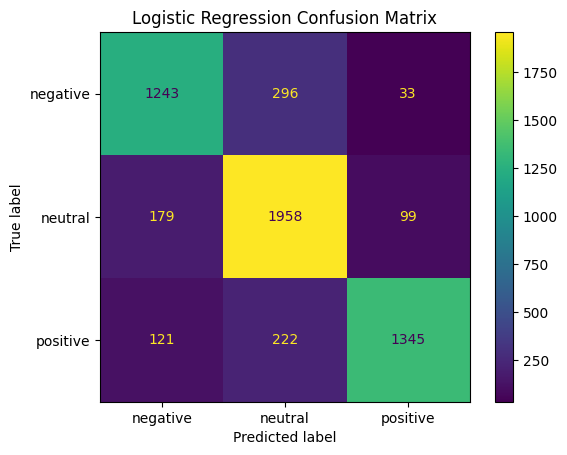


Confusion Matrix for SVM:


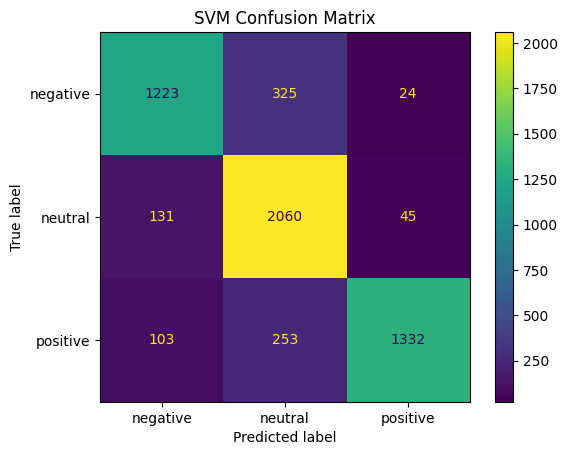


Confusion Matrix for Neural Network:


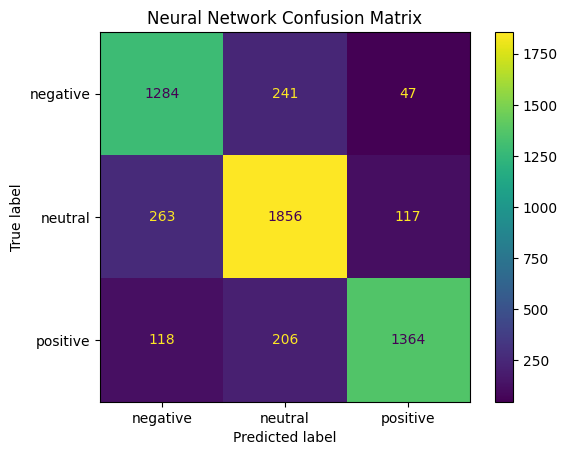

In [136]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Neural Network"],
    "Accuracy": [lr_accuracy, svm_accuracy, nn_accuracy],
    "Precision": [lr_precision, svm_precision, nn_precision],
    "Recall": [lr_recall, svm_recall, nn_recall],
    "F1-Score": [lr_f1, svm_f1, nn_f1]
})

print("\nModel Comparison:")
print(comparison)

# Plot Confusion Matrices for Comparison
print("\nConfusion Matrix for Logistic Regression:")
ConfusionMatrixDisplay.from_predictions(y_test, lr_predictions, display_labels=label_encoder.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print("\nConfusion Matrix for SVM:")
ConfusionMatrixDisplay.from_predictions(y_test, svm_predictions, display_labels=label_encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.show()

print("\nConfusion Matrix for Neural Network:")
ConfusionMatrixDisplay.from_predictions(y_test, nn_predictions, display_labels=label_encoder.classes_)
plt.title("Neural Network Confusion Matrix")
plt.show()
